In [9]:
!gdown 11gpLZOKw5-kJjYEaSaj613zaCA51eXVH
!unzip /content/drive/MyDrive/down_imagenet.zip -d down_imagenet

Streaming output truncated to the last 5000 lines.
  inflating: down_imagenet/train/car/car_0443.jpg  
  inflating: down_imagenet/train/car/car_0444.jpg  
  inflating: down_imagenet/train/car/car_0445.jpg  
  inflating: down_imagenet/train/car/car_0446.jpg  
  inflating: down_imagenet/train/car/car_0447.jpg  
  inflating: down_imagenet/train/car/car_0448.jpg  
  inflating: down_imagenet/train/car/car_0449.jpg  
  inflating: down_imagenet/train/car/car_0450.jpg  
  inflating: down_imagenet/train/car/car_0451.jpg  
  inflating: down_imagenet/train/car/car_0452.jpg  
  inflating: down_imagenet/train/car/car_0453.jpg  
  inflating: down_imagenet/train/car/car_0454.jpg  
  inflating: down_imagenet/train/car/car_0455.jpg  
  inflating: down_imagenet/train/car/car_0456.jpg  
  inflating: down_imagenet/train/car/car_0457.jpg  
  inflating: down_imagenet/train/car/car_0458.jpg  
  inflating: down_imagenet/train/car/car_0459.jpg  
  inflating: down_imagenet/train/car/car_0460.jpg  
  inflating: 

In [10]:
import os, random, string, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

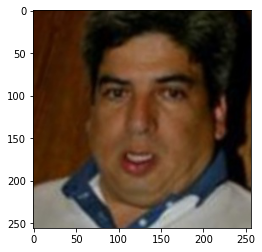

In [34]:
plt.imshow(Image.open('/content/down_imagenet/train/person/person_0009.jpg'))
plt.show()

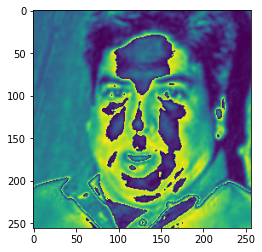

In [36]:
def single_channel_image(img):
  (B, G, R) = cv2.split(img)
  merged_channel = B+G+R
  normalized_channel_image = cv2.normalize(merged_channel, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  return normalized_channel_image

plt.imshow(single_channel_image(cv2.imread('/content/down_imagenet/train/person/person_0009.jpg')))

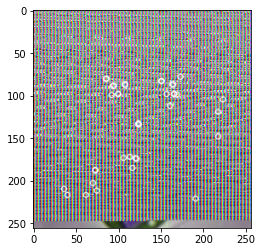

In [37]:
def apply_keypoints(img):
  akaze=cv2.AKAZE_create()
  queryKeypoints, queryDescriptors = akaze.detectAndCompute(img,None)
  empty_img = np.empty(img.shape, dtype=np.uint8)
  keypoints_img = cv2.drawKeypoints(empty_img, queryKeypoints, outImage = None, color=(255, 255, 255), flags=0)
  return keypoints_img

plt.imshow(apply_keypoints(cv2.imread('/content/down_imagenet/train/person/person_0009.jpg')))

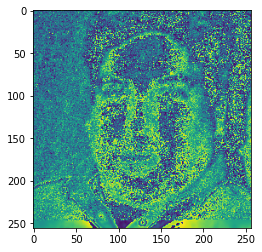

In [38]:
def apply_image_transormations(img):
  return single_channel_image(img) + single_channel_image(apply_keypoints(img))

plt.imshow(apply_image_transormations(cv2.imread('/content/down_imagenet/train/person/person_0009.jpg')))

In [15]:
datasetdir = '/content/down_imagenet'
import os
os.chdir(datasetdir)

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(preprocessing_function = preprocessing)

    height, width, channels = shape

    train_dataset = imgdatagen.flow_from_directory(
        datasetdir+'/train/',
        target_size = (height, width), 
        class_mode = 'categorical',
        batch_size = batch_size
    )

    val_dataset = imgdatagen.flow_from_directory(
        datasetdir+'/test/',
        target_size = (height, width), 
        class_mode = 'categorical',
        batch_size = batch_size
    )
    return train_dataset, val_dataset

In [17]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

# Resnet50

In [18]:
resnet50 = keras.applications.resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [19]:
train_dataset, val_dataset = generators((100, 100, 3), preprocessing=resnet50.preprocess_input)

Found 5959 images belonging to 8 classes.
Found 940 images belonging to 8 classes.


In [20]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# hidden layers
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
# softmax
predictions = keras.layers.Dense(8, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

In [21]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [22]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])

early_stopping = keras.callbacks.EarlyStopping('val_loss', mode='auto', patience=5)

history = full_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    steps_per_epoch = train_dataset.samples//train_dataset.batch_size,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
186/186 [==============================] - 41s 139ms/step - loss: 0.4792 - acc: 0.9232 - val_loss: 1.6271 - val_acc: 0.9181
Epoch 2/100
186/186 [==============================] - 24s 127ms/step - loss: 0.0906 - acc: 0.9833 - val_loss: 0.0622 - val_acc: 0.9755
Epoch 3/100
186/186 [==============================] - 24s 126ms/step - loss: 0.0167 - acc: 0.9958 - val_loss: 0.0632 - val_acc: 0.9840
Epoch 4/100
186/186 [==============================] - 25s 131ms/step - loss: 0.0205 - acc: 0.9953 - val_loss: 0.0557 - val_acc: 0.9819
Epoch 5/100
186/186 [==============================] - 24s 126ms/step - loss: 0.0077 - acc: 0.9988 - val_loss: 0.0763 - val_acc: 0.9840
Epoch 6/100
186/186 [==============================] - 24s 128ms/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0728 - val_acc: 0.9851
Epoch 7/100
186/186 [==============================] - 24s 127ms/step - loss: 0.0218 - acc: 0.9975 - val_loss: 0.1397 - val_acc: 0.9819
Epoch 8/100
186/186 [===========================

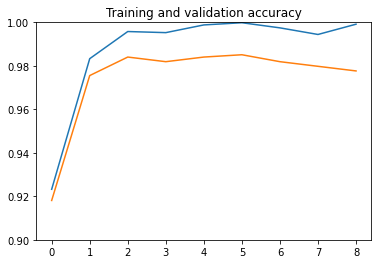

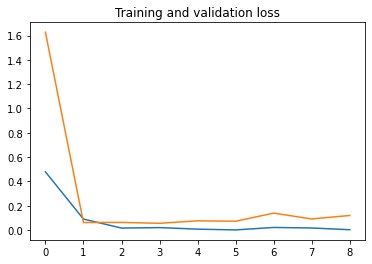

In [23]:
plot_history(history, yrange=(0.9,1))

In [24]:
full_model.save('/content/model_org.h5')

# Converting the image tensor from 3d to 2d and imposing feature descriptors and applying ResNet50

In [25]:
resnet50 = keras.applications.resnet50
# conv_model = resnet50.ResNet50(weights='imagenet', include_top=False)
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [26]:
def preprocess_input(img):
  img = np.array(img, dtype=np.uint8)
  akaze=cv2.AKAZE_create()
  queryKeypoints, queryDescriptors = akaze.detectAndCompute(img,None)
  keypoints_img = cv2.drawKeypoints(img,queryKeypoints,outImage = None,color=(255,255,255), flags=0)
  keypoints_img = single_channel_image(keypoints_img)
  empty_img = np.empty(keypoints_img.shape, dtype=np.uint8)
  transformed_img = cv2.merge((keypoints_img, empty_img, empty_img))
  return resnet50.preprocess_input(transformed_img)

In [27]:
train_dataset, val_dataset = generators((100, 100, 1), preprocessing=preprocess_input)

Found 5959 images belonging to 8 classes.
Found 940 images belonging to 8 classes.


In [28]:
# # changing th input layer of reset to work with a sigle channel image
# input_tensor = keras.layers.Input(shape=(100, 100, 1))
# x = keras.layers.Conv2D(3, (3,3), padding='same')(input_tensor) 
# x = conv_model(x) 
# flatten the output of the convolutional part: 
# x = keras.layers.Flatten()(x)
x = keras.layers.Flatten()(conv_model.output)
# hidden layers
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
# softmax
predictions = keras.layers.Dense(8, activation='softmax')(x)

# creating the full model:
# full_model = keras.models.Model(inputs=input_tensor, outputs=predictions)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

In [29]:
full_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

In [30]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])

early_stopping = keras.callbacks.EarlyStopping('val_loss', mode='auto', patience=3)

history = full_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    steps_per_epoch = train_dataset.samples//train_dataset.batch_size,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
186/186 [==============================] - 34s 152ms/step - loss: 0.7038 - acc: 0.7952 - val_loss: 0.3750 - val_acc: 0.8670
Epoch 2/100
186/186 [==============================] - 29s 151ms/step - loss: 0.1930 - acc: 0.9371 - val_loss: 0.2716 - val_acc: 0.9128
Epoch 3/100
186/186 [==============================] - 28s 146ms/step - loss: 0.0720 - acc: 0.9769 - val_loss: 0.3215 - val_acc: 0.9074
Epoch 4/100
186/186 [==============================] - 28s 146ms/step - loss: 0.0410 - acc: 0.9875 - val_loss: 0.5312 - val_acc: 0.8819
Epoch 5/100
186/186 [==============================] - 28s 147ms/step - loss: 0.0298 - acc: 0.9909 - val_loss: 0.4490 - val_acc: 0.9043


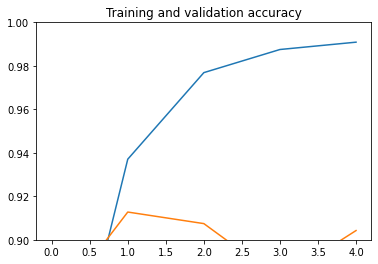

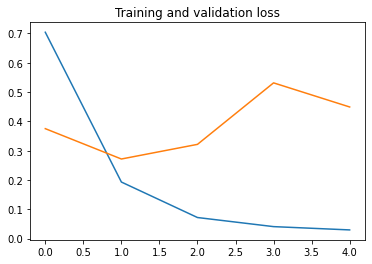

In [31]:
plot_history(history, yrange=(0.9,1))

In [32]:
full_model.save('/content/model_mod.h5')

In [33]:
# def predict_class(model, img_path, input_shape, class_indices=None):
#     class_indices = {value: key for key, value in class_indices.items()} if class_indices else None
#     data = np.expand_dims(preprocess_input(cv2.resize(cv2.imread(img_path), input_shape)), axis=0)
#     return class_indices.get(np.argmax(model.predict(data))) if class_indices else model.predict(data)

# predict_class(full_model, "/content/downn_imagennet/test/person/person_0009.png", (100, 100), class_indices=train_dataset.class_indices)